In [1]:
import cached  # joblib based memoization in ./cached.py
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import seaborn as sns
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

# %matplotlib notebook
%matplotlib inline

uncomment the following cell if editing ./cached.py

# Helper functions

## Network representation

In [2]:
def draw(G, size="compute", layout=None):
    size = dict(G.nodes(data=size)).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout


def print_(G):
    for l in nx.generate_graphml(G):
        print(l)

## Gini coefficient

copied from https://stackoverflow.com/a/39513799

In [3]:
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

# Network Spec

compute 2 [0.01 0.99]


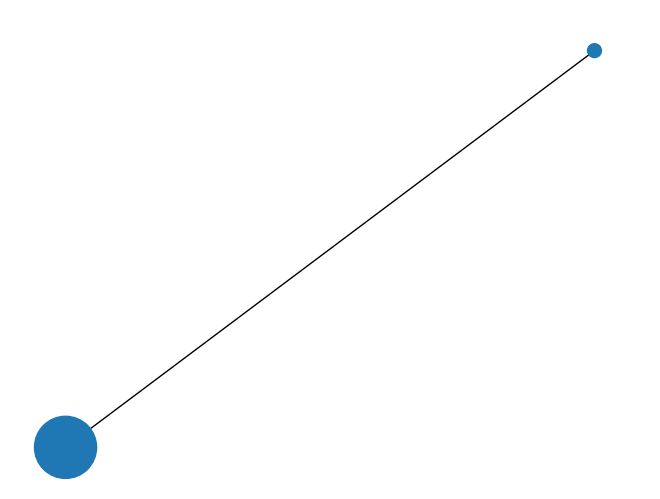

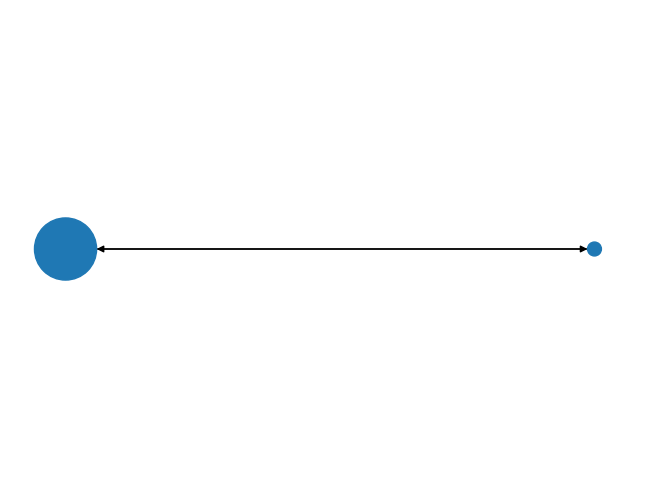

In [4]:
## Mining statistics for the last 7 days before Dec. 12 2022
## from https://www.blockchain.com/explorer/charts/pools
compute = [  # relative hash-rate # blocks mined / pool
    0.24817,  # 271 / Foundry USA
    0.20147,  # 220 / AntPool
    0.15110,  # 165 / F2Pool
    0.13736,  # 150 / Binance Pool
    0.10440,  # 114 / ViaBTC
    0.05311,  # 58  / Braiins Pool
    0.02473,  # 27  / Poolin
    0.01923,  # 21  / BTC.com
    0.01648,  # 18  / Luxor
    0.01465,  # 16  / Mara Pool
    0.00641,  # 7   / Ultimus
    0.00641,  # 7   / SBI Crypto
    0.00366,  # 4   / BTC M4
    0.00275,  # 3   / Titan
    # NaN    # 11  / Unknown
]
assert np.sum(compute) < 1
compute.append(1 - np.sum(compute))

## Simpler compute distributions for quick iteration

# compute = list(range(1, 8))
compute = [0.01, 0.99]
compute = compute / np.sum(compute)

## Communication

G = nx.complete_graph(len(compute))
G.graph["dissemination"] = "simple"

for i in range(len(compute)):
    G.nodes[i]["compute"] = compute[i]

for a, b in G.edges:
    # G.edges[a, b]["delay"] = f"uniform 0.5 1.5"
    G.edges[a, b]["delay"] = f"constant 6"  # 6 second constant message delay


## Output and checks

print("compute", len(compute), compute)
layout = nx.circular_layout(G)
draw(G, layout=layout)
plt.show()
res = cached.sim(G, activation_delay=600, activations=10000, protocol="nakamoto")
draw(res, size="reward", layout=layout)
plt.show()
# print_(G)

# Measurements

We are going to measure mean inequality and also volatility in rewards.

We know from previous results that the precision of the mean is linear in the number of activations. We should thus use the same number of activations for each reported mean.

For volatility, we fix the time frame (e.g. one day) and run multiple simulations for that length. Then we calculate standard deviation.

Now, activations per day depends on the activation delay. To get the mean estimates right, we run more fixed-time simulations for long activation delays and less simulations for short activation delays. Overall we maintain a constant number of activations across all observed fixed-time simulations.

In [5]:
def subblock_selection(x):
    return "heuristic"

    # altruistic obviously affects equality
    if x.k <= 32:
        return "heuristic"
    else:
        return "altruistic"


families = dict(
    nakamoto=lambda x: "nakamoto",
    bk=lambda x: f"bk-{x.k}-constant",
    bkll=lambda x: f"bkll-{x.k}-constant",
    tailstorm=lambda x: f"tailstorm-{x.k}-{x.scheme}-{subblock_selection(x)}",
    tailstormll=lambda x: f"tailstormll-{x.k}-{x.scheme}-{subblock_selection(x)}",
)


def rows():
    def r(f, k, s, ad, i, n):
        return pd.Series(
            dict(
                family=f,
                k=k,
                scheme=s,
                protocol=f"{f}-{k}-{s}",
                block_interval=ad * k,
                activation_delay=ad,
                seed=i,
                activations=n,
            )
        )

    activations = 1_000_000  # per protocol, split into slots of one day

    # nakamoto
    for bi in [75 / 8, 75 / 4, 75 / 2, 75, 150, 300, 600]:
        ad = bi
        n = int(60 * 60 * 24 / ad)  # time per simulation should be roughly one day
        for i in range(int(np.ceil(activations / n))):  # at least #activations pows
            yield r("nakamoto", 1, "constant", ad, i, n)

    # bk and tailstorm / 600s block interval
    for k in [2, 4, 8, 16, 32, 64]:
        bi = 600
        ad = bi / k
        n = int(60 * 60 * 24 / ad)  # time per simulation should be roughly one day
        for i in range(int(np.ceil(activations / n))):  # at least #activations pows
            yield r("bk", k, "constant", ad, i, n)
            yield r("tailstorm", k, "constant", ad, i, n)
            yield r("tailstorm", k, "discount", ad, i, n)

    # bk and tailstorm / 300s block interval
    for k in [2, 4, 8, 16, 32]:
        bi = 300
        ad = bi / k
        n = int(60 * 60 * 24 / ad)  # time per simulation should be roughly one day
        for i in range(int(np.ceil(activations / n))):  # at least #activations pows
            yield r("bk", k, "constant", ad, i, n)
            yield r("tailstorm", k, "constant", ad, i, n)
            yield r("tailstorm", k, "discount", ad, i, n)

    # bk and tailstorm / 150s block interval
    for k in [2, 4, 8, 16]:
        bi = 150
        ad = bi / k
        n = int(60 * 60 * 24 / ad)  # time per simulation should be roughly one day
        for i in range(int(np.ceil(activations / n))):  # at least #activations pows
            yield r("bk", k, "constant", ad, i, n)
            yield r("tailstorm", k, "constant", ad, i, n)
            yield r("tailstorm", k, "discount", ad, i, n)


def measure(x):
    res = cached.sim(
        G,
        activation_delay=x.activation_delay,
        activations=x.activations,
        protocol=families[x.family](x),
        seed=x.seed,
    )

    def read(G, field):
        return np.array([G.nodes[i][field] for i in range(len(G.nodes))])

    reward = read(res, "reward")
    activations = read(res, "activations")
    assert sum(activations) == x.activations
    compute = read(res, "compute")
    compute = compute / np.sum(compute)
    relrew = reward / np.sum(reward)
    relrewn = relrew / compute
    efficiency0 = reward / compute
    with np.errstate(divide="ignore", invalid="ignore"):
        efficiency1 = np.where(activations > 0, reward / activations, 0.0)
    weakest = np.argmin(compute)
    strongest = np.argmax(compute)
    return pd.Series(
        dict(
            machine_duration=res.graph["machine_duration"],
            chain_time=res.graph["chain_time"],
            progress=res.graph["progress"],
            height=res.graph["progress"] / x.k,
            reward=np.sum(reward),
            revenue_loss=1 - (np.sum(reward) / np.sum(activations)),
            weakest_reward=reward[weakest],
            weakest_relrew=relrew[weakest],
            weakest_relrewn=relrewn[weakest],
            weakest_efficiency0=efficiency0[weakest],
            weakest_efficiency1=efficiency1[weakest],
            strongest_reward=reward[strongest],
            strongest_relrew=relrew[strongest],
            strongest_relrewn=relrewn[strongest],
            strongest_efficiency0=efficiency0[strongest],
            strongest_efficiency1=efficiency1[strongest],
            gini_reward=gini(reward),
            gini_relrew=gini(relrew),
            gini_relrewn=gini(relrewn),
            gini_efficiency0=gini(efficiency0),
            gini_efficiency1=gini(efficiency1),
        )
    )


def parallel_measure(df, fun=measure, n_jobs=-1):
    df = df.sample(frac=1).reset_index(drop=True)

    res = Parallel(n_jobs=n_jobs)(
        delayed(measure)(row) for idx, row in tqdm(df.iterrows(), total=len(df))
    )
    return pd.concat([df, pd.DataFrame(res)], axis=1)


df = pd.DataFrame(rows())
display(df)
df = parallel_measure(df)

,family,k,scheme,protocol,block_interval,activation_delay,seed,activations
0,nakamoto,1,constant,nakamoto-1-constant,9.375,9.375,0,9216
1,nakamoto,1,constant,nakamoto-1-constant,9.375,9.375,1,9216
2,nakamoto,1,constant,nakamoto-1-constant,9.375,9.375,2,9216
3,nakamoto,1,constant,nakamoto-1-constant,9.375,9.375,3,9216
4,nakamoto,1,constant,nakamoto-1-constant,9.375,9.375,4,9216
...,...,...,...,...,...,...,...,...
49301,tailstorm,16,constant,tailstorm-16-constant,150.000,9.375,107,9216
49302,tailstorm,16,discount,tailstorm-16-discount,150.000,9.375,107,9216
49303,bk,16,constant,bk-16-constant,150.000,9.375,108,9216
49304,tailstorm,16,constant,tailstorm-16-constant,150.000,9.375,108,9216


  0%|          | 0/49306 [00:00<?, ?it/s]

# Analysis

## Table

In [6]:
display(
    df
    # .assign(family = pd.Categorical(df.family, categories=['nakamoto', 'bk', 'tailstorm']))
    .groupby(
        ["family", "k", "scheme", "block_interval", "activation_delay", "activations"]
    )
    .agg(
        chain_time_mean=("chain_time", np.mean),
        progress_mean=("progress", np.mean),
        height_mean=("height", np.mean),
        reward_mean=("reward", np.mean),
        weakest_rr_mean=("weakest_relrew", np.mean),
        weakest_rr_std=("weakest_relrew", np.std),
        strongest_rr_mean=("strongest_relrew", np.mean),
        strongest_rr_std=("strongest_relrew", np.std),
        rr_gini_mean=("gini_relrewn", np.mean),
        rr_gini_std=("gini_relrewn", np.std),
        nobs=("weakest_relrewn", len),
    )
    .query("nobs > 0")
    .sort_values(["k", "family", "scheme", "block_interval"])
    .reset_index()
    .assign(acc_activations=lambda d: d.activations * d.nobs)
)
display(compute)

,family,k,scheme,block_interval,activation_delay,activations,chain_time_mean,progress_mean,height_mean,reward_mean,weakest_rr_mean,weakest_rr_std,strongest_rr_mean,strongest_rr_std,rr_gini_mean,rr_gini_std,nobs,acc_activations
0,nakamoto,1,constant,9.375,9.375,9216,86363.779163,9149.532110,9149.532110,9149.532110,0.002882,0.000626,0.997118,0.000626,0.279289,0.037166,109,1004544
1,nakamoto,1,constant,18.750,18.750,4608,86315.096943,4585.743119,4585.743119,4585.743119,0.005410,0.001067,0.994590,0.001067,0.153134,0.046220,218,1004544
2,nakamoto,1,constant,37.500,37.500,2304,86352.954928,2297.565517,2297.565517,2297.565517,0.007513,0.001799,0.992487,0.001799,0.081821,0.053201,435,1002240
3,nakamoto,1,constant,75.000,75.000,1152,86434.969054,1150.287687,1150.287687,1150.287687,0.008722,0.002688,0.991278,0.002688,0.070982,0.058860,869,1001088
4,nakamoto,1,constant,150.000,150.000,576,86432.847145,575.545193,575.545193,575.545193,0.009335,0.004083,0.990665,0.004083,0.095194,0.080529,1737,1000512
5,nakamoto,1,constant,300.000,300.000,288,86518.442821,287.891736,287.891736,287.891736,0.009768,0.005885,0.990232,0.005885,0.135576,0.120417,3473,1000224
6,nakamoto,1,constant,600.000,600.000,144,86365.857733,143.971058,143.971058,143.971058,0.009765,0.008203,0.990235,0.008203,0.207188,0.172203,6945,1000080
7,bk,2,constant,150.000,75.000,1152,86400.231293,1150.227848,575.113924,1150.227848,0.009525,0.002809,0.990475,0.002809,0.062253,0.051873,869,1001088
8,bk,2,constant,300.000,150.000,576,86400.569831,575.416235,287.708117,575.416235,0.009775,0.004166,0.990225,0.004166,0.091010,0.075626,1737,1000512
9,bk,2,constant,600.000,300.000,288,86497.713113,287.850274,143.925137,287.850274,0.009990,0.005924,0.990010,0.005924,0.133238,0.118590,3473,1000224


array([0.01, 0.99])

# Nakamoto as benchmark

Fast and slow. Block interval 9.375s on the left to 600s on the right.

## Relative reward of weakest miner

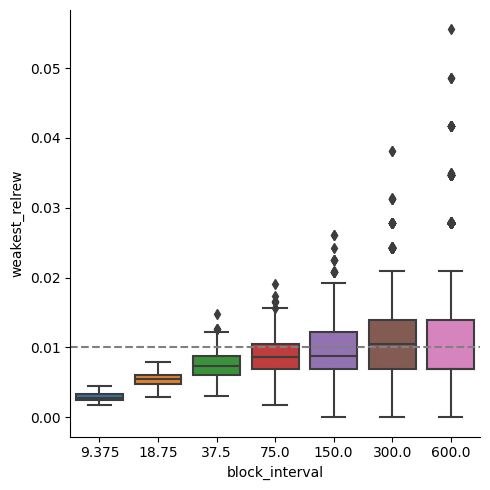

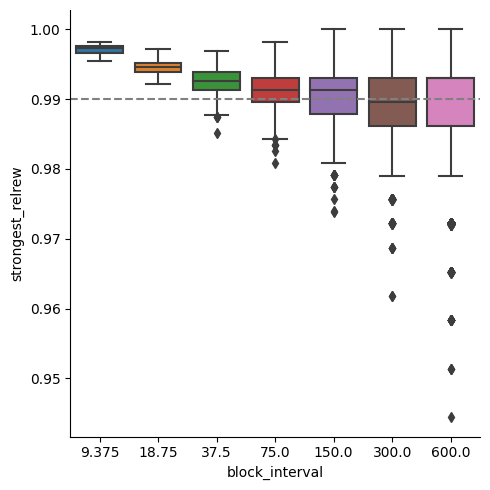

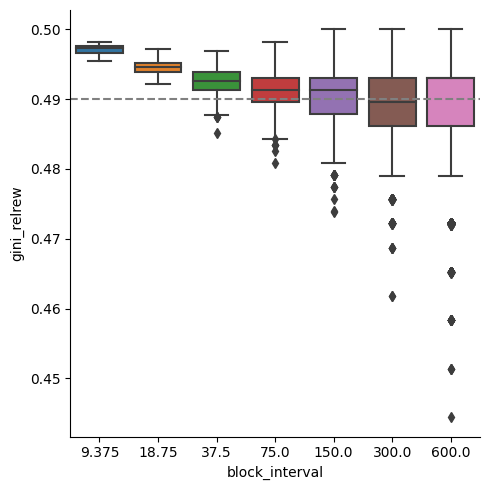

In [7]:
for metric, ref in [
    ("weakest_relrew", np.min),
    ("strongest_relrew", np.max),
    ("gini_relrew", gini),
]:
    ax = sns.catplot(
        kind="box", data=df.query("family=='nakamoto'"), y=metric, x="block_interval"
    )
    ax.refline(y=ref(compute))
    plt.show()

# New protocols

For different k's. From k = 2 on the left to k = 64 on the right. Block interval on the facet.

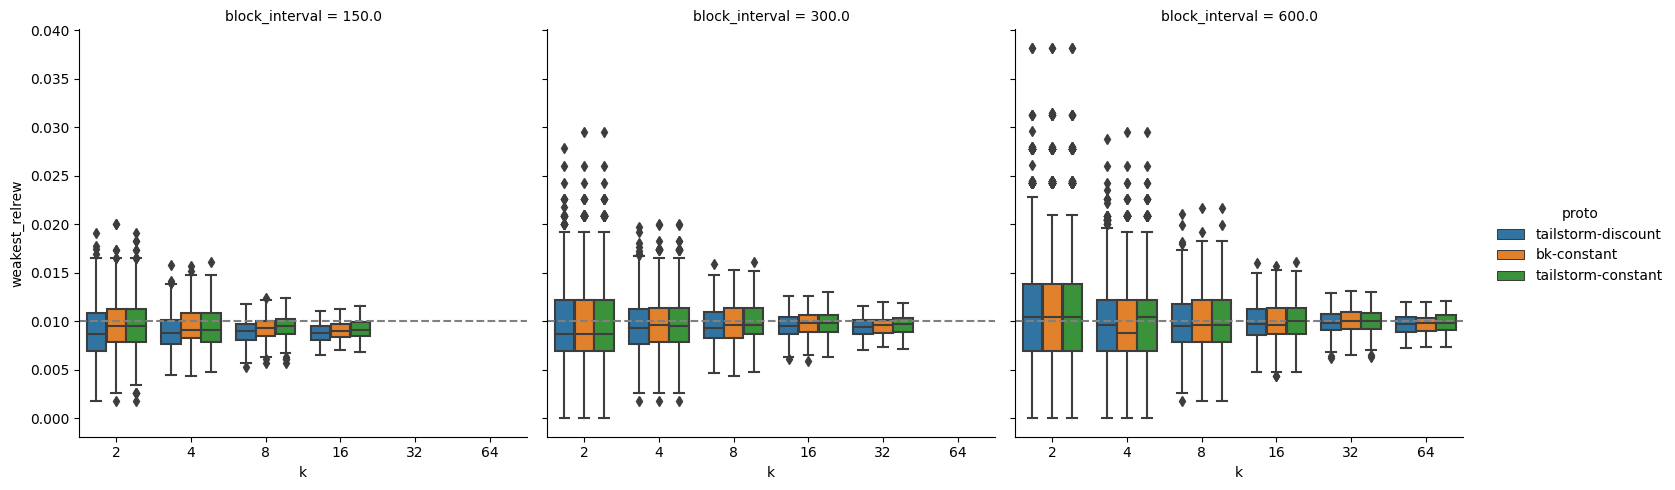

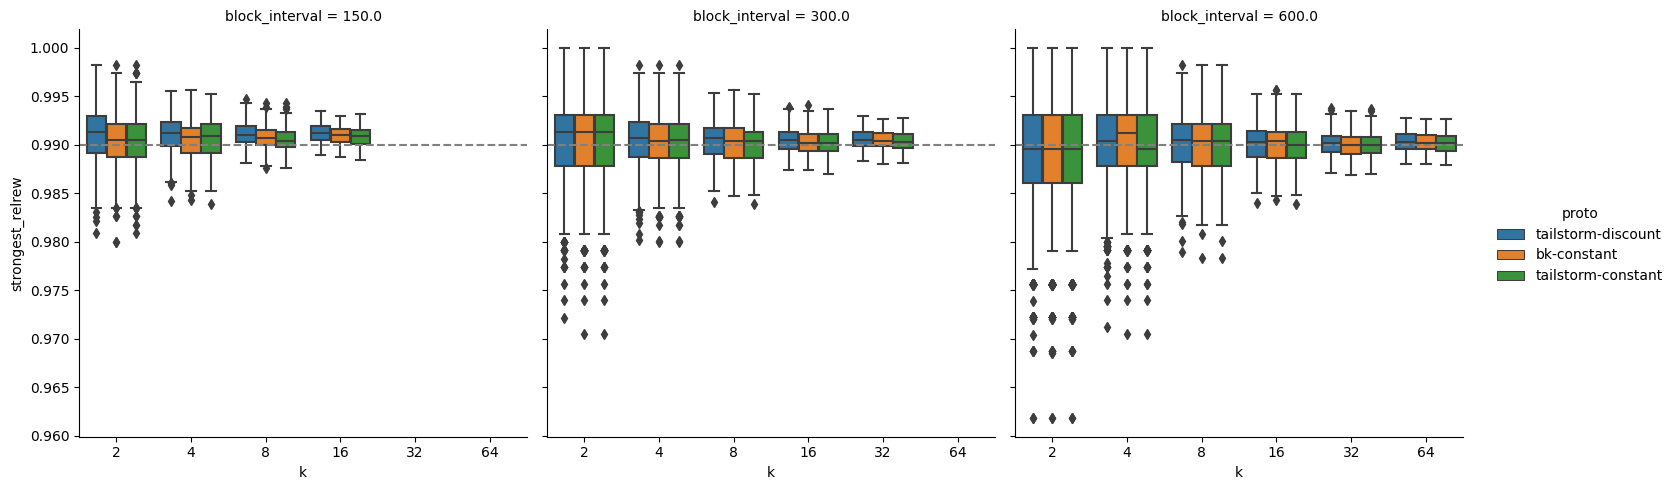

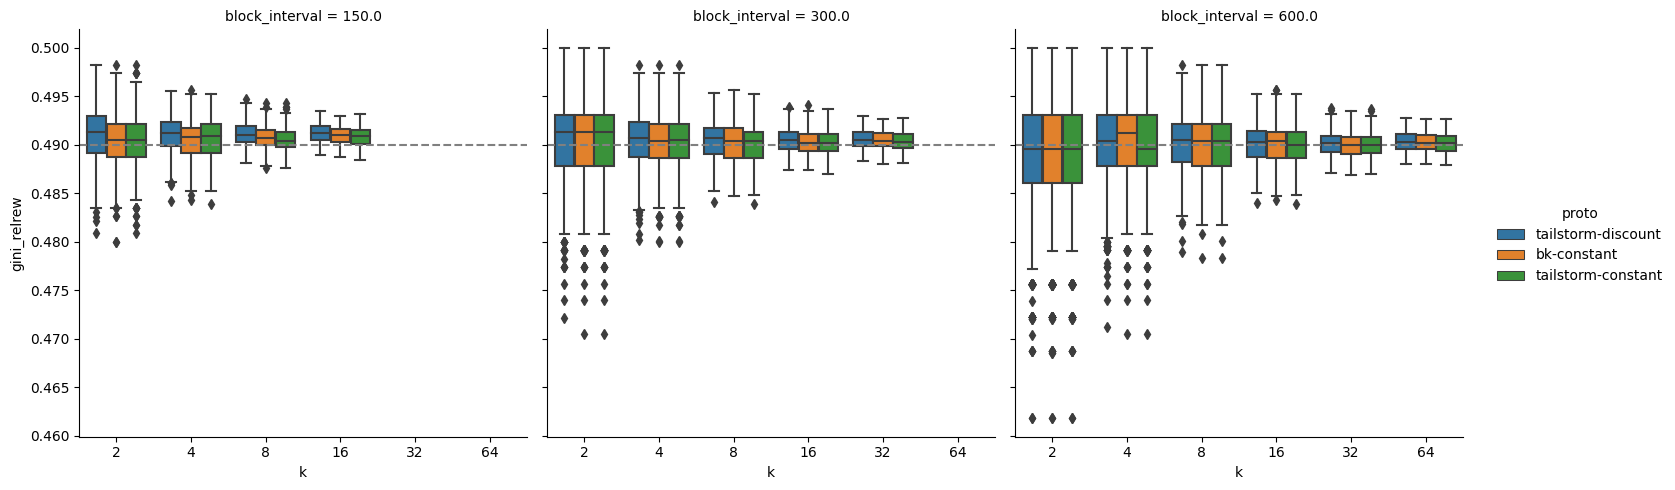

In [8]:
for metric, ref in [
    ("weakest_relrew", np.min),
    ("strongest_relrew", np.max),
    ("gini_relrew", gini),
]:
    ax = sns.catplot(
        kind="box",
        data=df.query("family!='nakamoto'").assign(
            k=lambda d: d.k.astype("category"),
            proto=lambda d: d.family + "-" + d.scheme,
        ),
        hue="proto",
        # style="scheme",
        y=metric,
        x="k",
        col="block_interval",
    )
    ax.refline(y=ref(compute))
    plt.show()

# All in One

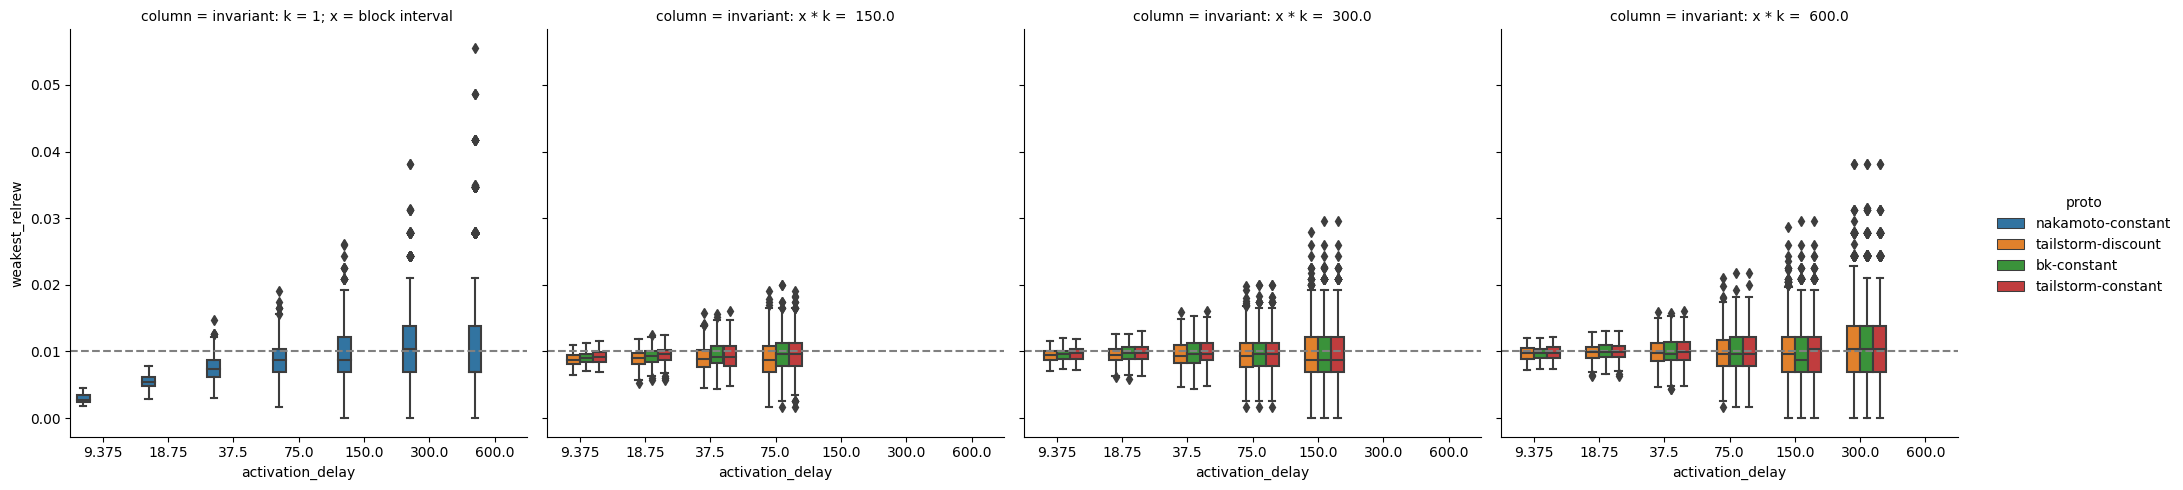

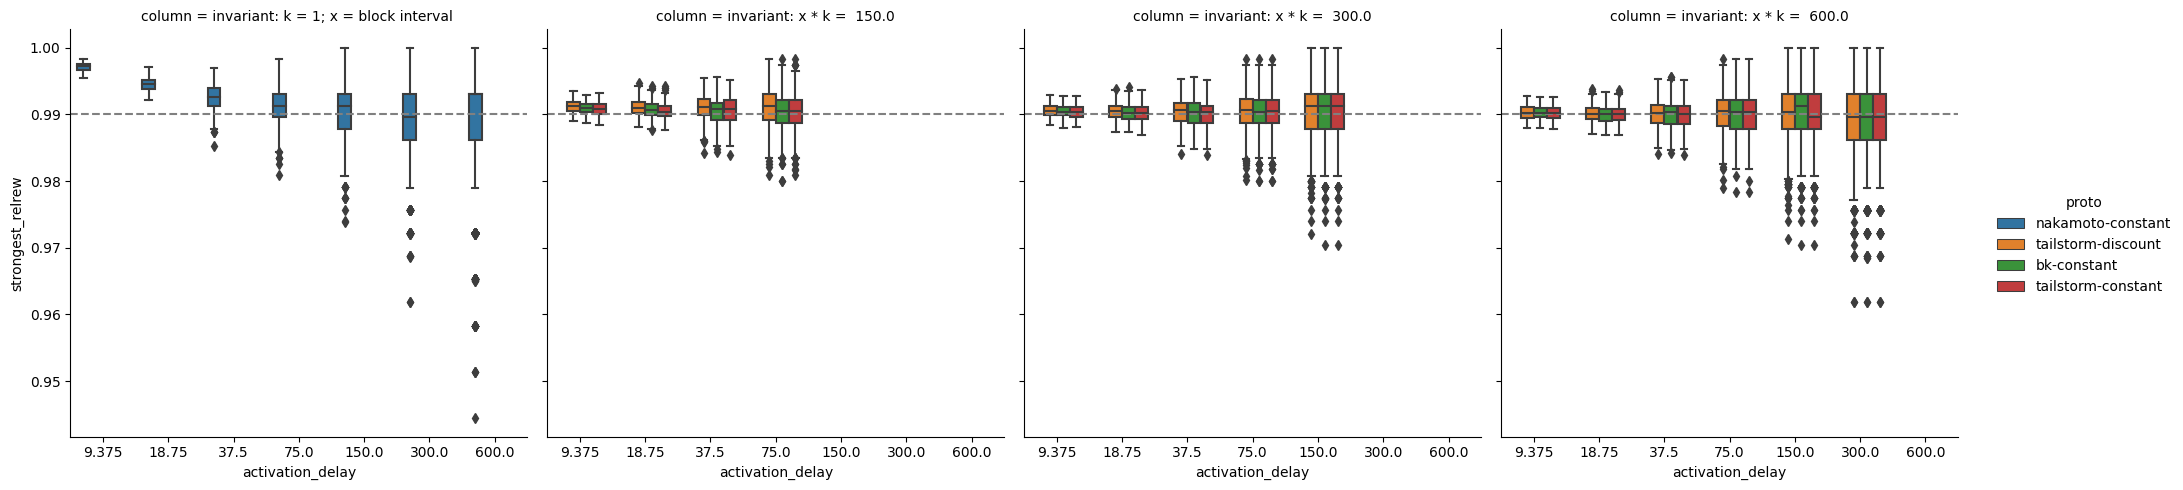

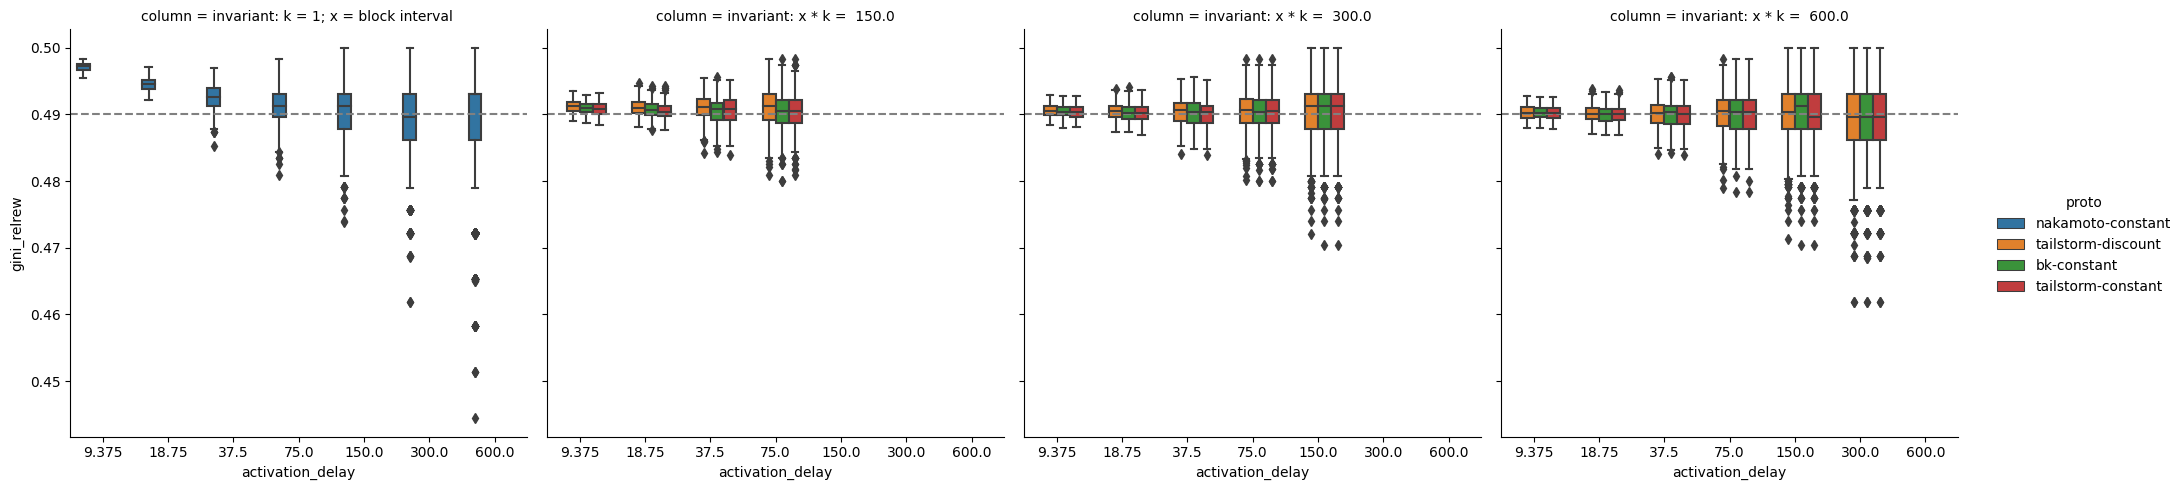

In [9]:
d = df.copy()
d.loc[d.family == "nakamoto", "column"] = "invariant: k = 1; x = block interval "
d.loc[d.family != "nakamoto", "column"] = "invariant: x * k =  " + d.loc[
    d.family != "nakamoto", "block_interval"
].map(str)

for metric, ref in [
    ("weakest_relrew", np.min),
    ("strongest_relrew", np.max),
    ("gini_relrew", gini),
]:
    g = sns.catplot(
        kind="box",
        data=d.assign(
            proto=lambda d: d.family + "-" + d.scheme,
        ),
        hue="proto",
        # style="scheme",
        y=metric,
        x="activation_delay",
        col="column",
        col_order=sorted(list(set(d.column))),
    )
    g.refline(y=ref(compute))
    # g.axes[0][0].invert_xaxis()
    plt.show()

# Selected Plots

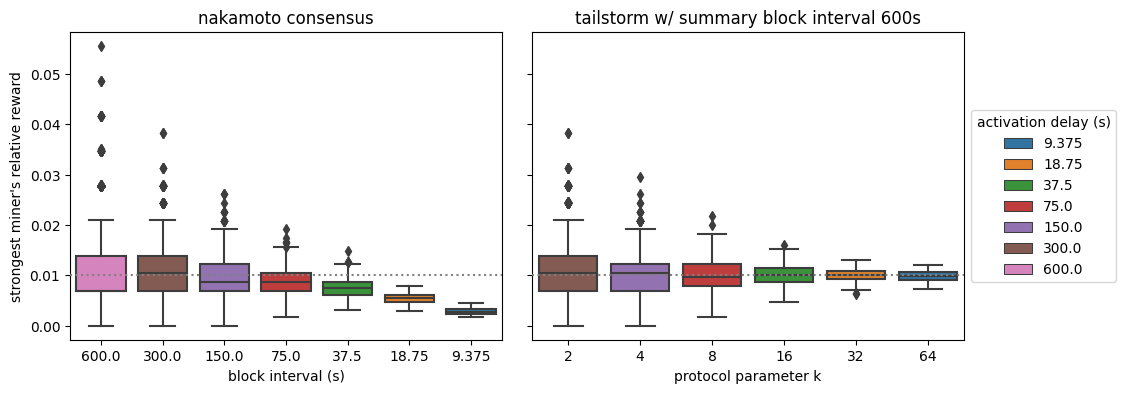

In [10]:
metric = "weakest_relrew"
ref = np.min

# metric = "strongest_relrew"
# ref = np.max

# metric = 'gini_relrew'
# ref = gini

fig = plt.figure(figsize=[12, 4])
ax1, ax2 = fig.subplots(1, 2, sharey=True)

g = sns.boxplot(
    data=df.query('family == "nakamoto"'),
    x="block_interval",
    y=metric,
    ax=ax1,
    hue="activation_delay",
    dodge=False,
)
g.axhline(y=ref(compute), color="gray", ls="dotted", zorder=3)
g.set(
    xlabel="block interval (s)",
    ylabel="strongest miner's relative reward",
    title="nakamoto consensus",
)
ax1.invert_xaxis()

g = sns.boxplot(
    data=df.query(
        'family == "tailstorm" and scheme=="constant" and block_interval==600'
    ),
    x="k",
    y=metric,
    ax=ax2,
    hue="activation_delay",
    dodge=False,
)
g.axhline(y=ref(compute), color="gray", ls="dotted", zorder=3)
g.set(
    xlabel="protocol parameter k",
    ylabel="",
    title="tailstorm w/ summary block interval 600s",
)


handles, labels = ax1.get_legend_handles_labels()
ax1.legend([], [], frameon=False)
ax2.legend([], [], frameon=False)
fig.legend(handles, labels, loc="center right", title="activation delay (s)")
fig.subplots_adjust(right=0.87, wspace=0.07)

plt.show()

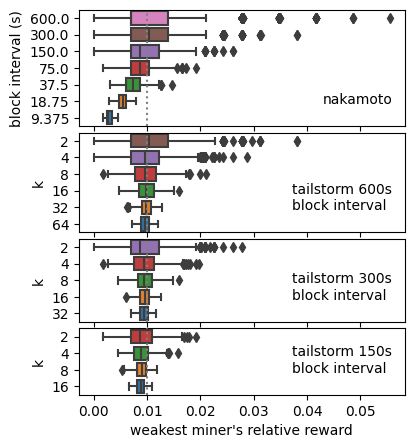

In [14]:
metric = "weakest_relrew"
ref = np.min
label = "weakest miner's relative reward"

# metric = "strongest_relrew"
# ref = np.max
# label = "strongest miner's relative reward"

# metric = 'gini_relrew'
# ref = gini
# label = "Gini coefficient of relative rewards"

fig = plt.figure(figsize=[3.62, 5])
ax1, ax2, ax3, ax4 = fig.subplots(4, 1, sharex=True, height_ratios=[7, 6, 5, 4])

g = sns.boxplot(
    data=df.query('family == "nakamoto"'),
    y="block_interval",
    x=metric,
    orient="h",
    ax=ax1,
    hue="activation_delay",
    dodge=False,
)
g.axvline(x=ref(compute), color="gray", ls="dotted", zorder=3)
g.set(
    xlabel="",
    ylabel="block interval (s)",
    title="",
)
ax1.invert_yaxis()

g = sns.boxplot(
    data=df.query(
        'family == "tailstorm" and scheme=="discount" and block_interval==600'
    ),
    y="k",
    x=metric,
    orient="h",
    ax=ax2,
    hue="activation_delay",
    dodge=False,
)
g.axvline(x=ref(compute), color="gray", ls="dotted", zorder=3)
g.set(
    ylabel="k",
    xlabel=label,
    title="",
)

g = sns.boxplot(
    data=df.query(
        'family == "tailstorm" and scheme=="discount" and block_interval==300'
    ),
    y="k",
    x=metric,
    orient="h",
    ax=ax3,
    hue="activation_delay",
    dodge=False,
)
g.axvline(x=ref(compute), color="gray", ls="dotted", zorder=3)
g.set(
    ylabel="k",
    xlabel=label,
    title="",
)

g = sns.boxplot(
    data=df.query(
        'family == "tailstorm" and scheme=="discount" and block_interval==150'
    ),
    y="k",
    x=metric,
    orient="h",
    ax=ax4,
    hue="activation_delay",
    dodge=False,
)
g.axvline(x=ref(compute), color="gray", ls="dotted", zorder=3)
g.set(
    ylabel="k",
    xlabel=label,
    title="",
)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend([], [], title="nakamoto", frameon=False)
ax2.legend(
    [], [], title="tailstorm 600s\nblock interval", frameon=False, loc="lower right"
)
ax3.legend(
    [], [], title="tailstorm 300s\nblock interval", frameon=False, loc="lower right"
)
ax4.legend(
    [], [], title="tailstorm 150s\nblock interval", frameon=False, loc="lower right"
)
# fig.legend(handles, labels, loc="lower left", title="activation delay (s)", ncols=4)
# fig.subplots_adjust(bottom=0.22, hspace=0.07, wspace=0, left=0)
fig.subplots_adjust(hspace=0.07, wspace=0, left=0)

plt.show()

fig.savefig(
    "inequality.png", dpi=600, bbox_inches="tight", transparent=True, pad_inches=0
)

# ToDo

- tex the table, w/ less cells